In [1]:
from src import Model

import pytorch_lightning as pl
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import random
from torchvision.models import densenet121
from pathlib import Path
from torchvision import datasets, transforms
from monai.data import CacheDataset, DataLoader
from monai.transforms import Lambdad, ToTensord, \
    RandAdjustContrastd,RandGaussianNoised, ScaleIntensityd, \
    RandRotate90d, RandFlipd, Compose
from PIL import Image
from torchmetrics import AUROC
from pytorch_lightning.callbacks import LearningRateMonitor
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR


In [20]:
class BenefitDataset(pl.LightningDataModule):
    def __init__(self, train_paths, val_paths, test_paths):
        super().__init__()

        self.train_paths = train_paths
        self.val_paths = val_paths
        self.test_paths = test_paths

        self.train_transform=Compose([
            Lambdad(['image'], lambda x: np.array(Image.open(x)).transpose(2,0,1).astype(np.float32)),   
            ScaleIntensityd(['image']),
            RandRotate90d(['image'], prob=0.75),
            RandFlipd(['image'], prob=0.5, spatial_axis=0),
            RandFlipd(['image'], prob=0.5, spatial_axis=1),
            ToTensord(keys=['image']),
            RandAdjustContrastd(['image'], prob=0.5, gamma=(0.5,2)),
        ])
        self.test_transform=Compose([
            Lambdad(['image'], lambda x: np.array(Image.open(x)).transpose(2,0,1).astype(np.float32)),
            ScaleIntensityd(['image']),
            ToTensord(keys=['image']),
            
        ])

    def setup(self, stage=None):
        df = pd.DataFrame(
            data=['train']*len(self.train_paths) \
                + ['val']*len(self.val_paths) \
                + ['test']*len(self.test_paths),
            columns=['fold'],
            index= self.train_paths+self.val_paths+self.test_paths
        )

        df['patient'] = [x.stem.split('_')[0].replace('-','_') for x in df.index]

        dmtr = pd.read_csv('/home/rens/repos/PREMIUM/code/radiomics_paper/dmtr.csv').set_index('id')
        dcb = []
        for patient in df.patient:
            try:
                dcb.append(dmtr.loc[patient, 'dcb'])
            except:
                dcb.append(float('nan'))
        df['dcb'] = dcb

        df = df[~df.dcb.isna()]
        df['dcb'] = df['dcb'].astype(int)

        if stage == 'fit' or stage is None:
            self.train_input = self.df_to_input(df[df.fold=='train'])
            self.val_input = self.df_to_input(df[df.fold=='val'])
        if stage == 'test' or stage is None:
            self.test_input = self.df_to_input(df[df.fold=='test'])
    
    def make_dataloader(self, input, transform, shuffle=False):
        ds = CacheDataset(input, transform=transform, cache_rate=0)
        dl = DataLoader(ds, batch_size=16, shuffle=shuffle, num_workers=12)
        
        return dl

    def train_dataloader(self):
        return self.make_dataloader(self.train_input, self.train_transform, shuffle=False)

    def val_dataloader(self):
        return self.make_dataloader(self.val_input, self.test_transform,)

    def test_dataloader(self):
        return self.make_dataloader(self.test_input, self.test_transform,)

    def df_to_input(self, df):
            return [
                {'path':str(ix),
                'image':str(ix),
                'label':r['dcb']}
                for ix, r in df.iterrows()
            ]

In [38]:
paths = list(Path('/home/rens/hpc/rens/output/patches/isala_metastasis_level4').iterdir())

df = pd.DataFrame(
    data=[p.stem.split('_')[0].replace('-','_') for p in paths],
    index=paths,
    columns=['patient']
)

patients = df.patient.unique()
random.shuffle(patients)

train = df[df.patient.isin(patients[:37])].index.tolist()
val = df[df.patient.isin(patients[37:47])].index.tolist()
test = df[df.patient.isin(patients[47:])].index.tolist()

ds = BenefitDataset(train, val, test)
ds.setup()

Columns (2,24,26,111,115,200,204,361,363,375,416,422,451,470,477,480,521,524,547,585,591,654,667,733,757,765,767,768,769,770,771,773,774,775,776,777,779,780,781,782,833,836,844,847,848,854,857,858,860,861,862,864,865,867,868,869,876,877,879,880,881,882,883,885,886,887,888,889,891,892,893,894,895,897,898,899,912,913,915,916,917,918,919,921,922,923,924,925,927,928,929,930,931,933,934,935) have mixed types.Specify dtype option on import or set low_memory=False.


In [21]:
train = list(Path('/home/rens/hpc/rens/output/patches/isala_metastasis_level4').iterdir())
val = list(Path('/home/rens/hpc/rens/output/patches/radboud_metastasis_level4').iterdir())
test = list(Path('/home/rens/hpc/rens/output/patches/mst_metastasis_level4').iterdir())

ds = BenefitDataset(train, val, test)
ds.setup()

Columns (2,24,26,111,115,200,204,361,363,375,416,422,451,470,477,480,521,524,547,585,591,654,667,733,757,765,767,768,769,770,771,773,774,775,776,777,779,780,781,782,833,836,844,847,848,854,857,858,860,861,862,864,865,867,868,869,876,877,879,880,881,882,883,885,886,887,888,889,891,892,893,894,895,897,898,899,912,913,915,916,917,918,919,921,922,923,924,925,927,928,929,930,931,933,934,935) have mixed types.Specify dtype option on import or set low_memory=False.


In [39]:
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor

seed_everything(5)

model = Model()
logger = TensorBoardLogger('tb_logs', name='07_benefit')
lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = Trainer(
    gpus=1,
    max_epochs=10,
    logger=logger,
    fast_dev_run=False,
    num_sanity_val_steps=0,
    # callbacks=[lr_monitor],
)

trainer.fit(model, ds)
trainer.test(model, ds)

model.results.to_csv('/home/rens/hpc/rens/output/patches/benefit_predictions_v3.csv')

Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | DenseNet | 7.0 M 
-----------------------------------
1.0 K     Trainable params
7.0 M     Non-trainable params
7.0 M     Total params
27.820    Total estimated model params size (MB)


Epoch 1:   0%|          | 0/156 [00:00<00:00, 1004.38it/s, loss=0.667, v_num=25] 

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.


Epoch 9: 100%|██████████| 156/156 [00:11<00:00, 14.20it/s, loss=0.554, v_num=25] 

DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 21/21 [00:01<00:00, 15.59it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 21/21 [00:01<00:00, 10.69it/s]


Columns (2,24,26,111,115,200,204,361,363,375,416,422,451,470,477,480,521,524,547,585,591,654,667,733,757,765,767,768,769,770,771,773,774,775,776,777,779,780,781,782,833,836,844,847,848,854,857,858,860,861,862,864,865,867,868,869,876,877,879,880,881,882,883,885,886,887,888,889,891,892,893,894,895,897,898,899,912,913,915,916,917,918,919,921,922,923,924,925,927,928,929,930,931,933,934,935) have mixed types.Specify dtype option on import or set low_memory=False.


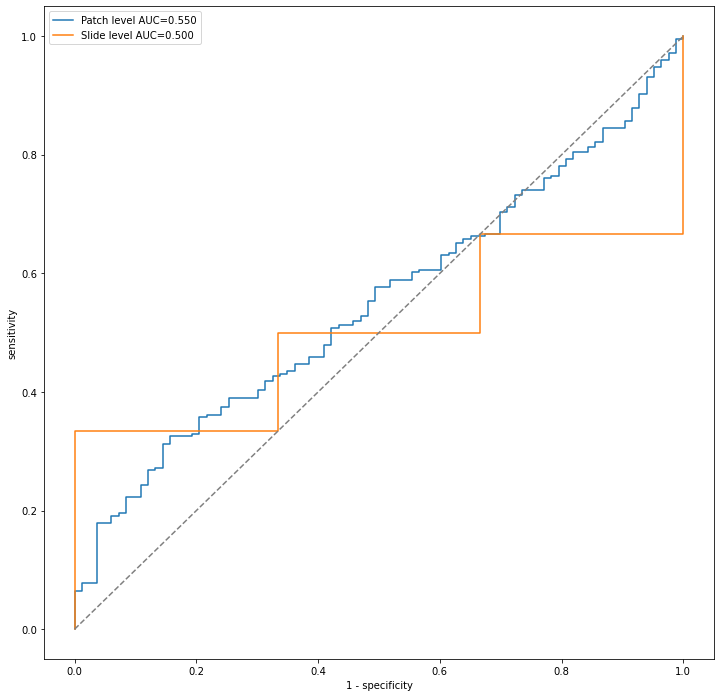

In [41]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

r = Path('/home/rens/hpc/rens/output/patches')
dmtr = pd.read_csv('/home/rens/repos/PREMIUM/code/radiomics_paper/dmtr.csv').set_index('id')

df = pd.read_csv(r / 'benefit_predictions_v3.csv').set_index('Unnamed: 0')
df['x'] = [int(ix.split('x')[-1].split('_')[0]) for ix in df.index]
df['y'] = [int(ix.split('y')[-1].split('.')[0]) for ix in df.index]

paths = []
for ix in df.index:
    filename = '_'.join(ix.split('_')[:-2]).split('/')[-1] + '.ndpi'
    if 'primary' in ix:
        path = Path('/home/rens/hpc/PREMIUM histopathology/data/isala/primary') / filename
    elif 'metastasis' in ix:
        path = Path('/home/rens/hpc/PREMIUM histopathology/data/isala/metastasis') / filename
    else:
        raise Exception('neither primary nor metastasis')
    paths.append(str(path))
df['slide'] = paths
df['patient'] = [ix.split('/')[-1].split('_')[0].replace('-','_') for ix in df.index]
dcb = []
for patient in df.patient:
    try:
        dcb.append(dmtr.loc[patient, 'dcb'])
    except:
        dcb.append(float('nan'))
df['dcb'] = dcb

plt.figure(figsize=(12,12))

# patch level
fpr, tpr, _ = roc_curve(df.dcb, df.pred)
auc = roc_auc_score(df.dcb, df.pred)
plt.plot(fpr, tpr, label=f'Patch level AUC={auc:.3f}')

# slide level
slide_level_df = df.groupby('slide')[['pred','dcb']].mean()
fpr, tpr, _ = roc_curve(slide_level_df.dcb, slide_level_df.pred)
auc = roc_auc_score(slide_level_df.dcb, slide_level_df.pred)
plt.plot(fpr, tpr, label=f'Slide level AUC={auc:.3f}')

plt.plot([0,1],[0,1], linestyle='--', c='gray')

plt.xlabel('1 - specificity')
plt.ylabel('sensitivity')
plt.legend()
plt.show()